# Survival Analysis

## Import Libraries

In [1]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

In [2]:
# Import libraries for plotting the graphs
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [3]:
# Set theme
sns.set_theme(style='white')

## Read File


Also, create the X and Y axis for the model to fit

In [4]:
df = pd.read_pickle('../Data/Combined_Datasets/dfCOG.pkl')
df_aml02 = pd.read_pickle('../Data/Combined_Datasets/dfaml02.pkl')
df_aml08 = pd.read_pickle('../Data/Combined_Datasets/dfaml08.pkl')
df03p1 = pd.read_pickle('../Data/Combined_Datasets/df03p1.pkl')

In [5]:
# COG:
print('Discovery (train) Dataset:')

x = df.iloc[:,:(df.shape[1] - 81)]
y = df.iloc[:,(df.shape[1] - 81):]
print(f'\ndf AAML1031 and AAML0531: {df.shape}\n y: {y.shape}\n x: {x.shape}')

print('\nValidation (test) Datasets:\n')

# AML02:
df_aml02 = pd.read_pickle('../Data/Combined_Datasets/dfaml02.pkl')
x_aml02 = df_aml02.iloc[:,:(df_aml02.shape[1] - 111)]
y_aml02 = df_aml02.iloc[:,(df_aml02.shape[1] - 111):]
print(f'\ndf AML02: {df_aml02.shape}\n y_aml02: {y_aml02.shape}\n x_aml02: {x_aml02.shape}')

# AML08:

x_aml08 = df_aml08.iloc[:,:(df_aml08.shape[1] - 112)]
y_aml08 = df_aml08.iloc[:,(df_aml08.shape[1]) - 112:]
print(f'\ndf AML08: {df_aml08.shape}\n y_aml08: {y_aml08.shape}\n x_aml08: {x_aml08.shape}')

# AAML03P1

x_03p1 = df03p1.iloc[:,:(df03p1.shape[1] - 81)]
y_03p1 = df03p1.iloc[:,(df03p1.shape[1] - 81):]
print(f'\ndf AAML03P1: {df03p1.shape}\n y_03p1: {y_03p1.shape}\n x_03p1: {x_03p1.shape}')


Discovery (train) Dataset:

df AAML1031 and AAML0531: (1028, 309049)
 y: (1028, 81)
 x: (1028, 308968)

Validation (test) Datasets:


df AML02: (164, 354874)
 y_aml02: (164, 111)
 x_aml02: (164, 354763)

df AML08: (42, 354885)
 y_aml08: (42, 112)
 x_aml08: (42, 354773)

df AAML03P1: (36, 309049)
 y_03p1: (36, 81)
 x_03p1: (36, 308968)


In [6]:
merge = pd.concat([x,x_aml02], axis=0, join='inner')

In [7]:
x = x[merge.columns]
x_aml02 = x_aml02[merge.columns]
x_aml08 = x_aml08[merge.columns]
x_03p1 = x_03p1[merge.columns]

In [8]:
labels = pd.read_excel('../Data/Combined_Datasets/labelsCOG_WHOClass.xlsx', index_col=0)
labels2 = labels[labels.index.isin(list(y.index))]

## Vizualize Beta Value Distribution

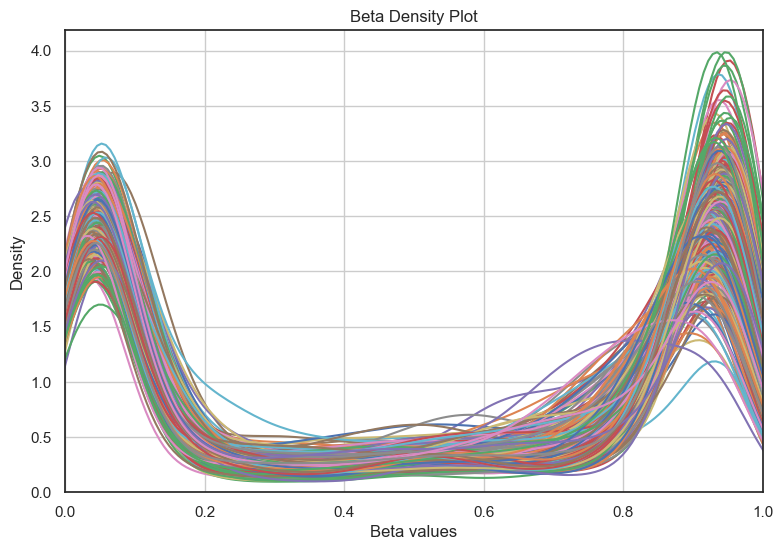

In [9]:
import methylcheck

methylcheck.beta_density_plot(x.T, figsize=(9,6), reduce=0.1)

## Transform to M-Values

In [10]:
# Define Function
import math
def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = x.apply(np.vectorize(beta2m))
x_test1_m = x_aml02.apply(np.vectorize(beta2m))
x_test2_m = x_aml08.apply(np.vectorize(beta2m))
x_test3_m = x_03p1.apply(np.vectorize(beta2m))

In [11]:
# Get correlation between Beta and M Values
corr = x_train_m.corrwith(x, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),x.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

In [12]:
import scipy.stats as stats

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
                 bbox_inches='tight', dpi=300)

    return(plt.show())

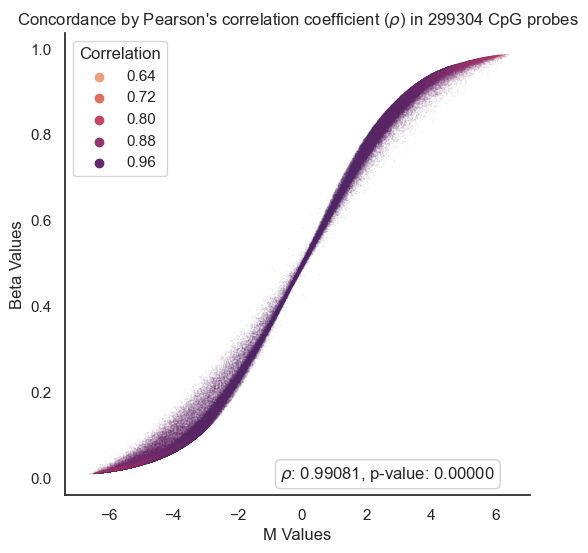

In [13]:
draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Run UMAP

In [14]:
import umap

In [15]:

reducer = umap.UMAP(n_neighbors=8, min_dist=0.01, n_jobs=-1, n_epochs=1000,learning_rate=0.1, random_state=42)
x_umap_fit = reducer.fit(x_train_m)

In [16]:
x_umap = x_umap_fit.transform(x_train_m)

In [447]:
def draw_UMAP(score,hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    # Define scatterplot
    plt.subplots(figsize=(7, 5)) 
    sns.scatterplot(data=labels2, x=xs, y=ys,
                    s=20,hue=hue,
                    linewidth=0, alpha=0.8)

    # Define plot specs
    if hue != None:
        plt.title("UMAP by " + hue + ", n= "+ str(len(score2)),
                  fontsize = 12)
        plt.savefig('../Figures/UMAP/' + hue + '.png',
                    bbox_inches='tight', dpi=300)
    else:
        plt.title("UMAP Projection, n= "+ str(len(score2)),
                  fontsize = 12)
        plt.savefig('../Figures/UMAP/UMAP_Projection.png',
                    bbox_inches='tight', dpi=300)
          
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)           
    plt.xlabel("UMAP{}".format(1))
    plt.ylabel("UMAP{}".format(2))
    plt.tight_layout()

    return(plt.show())

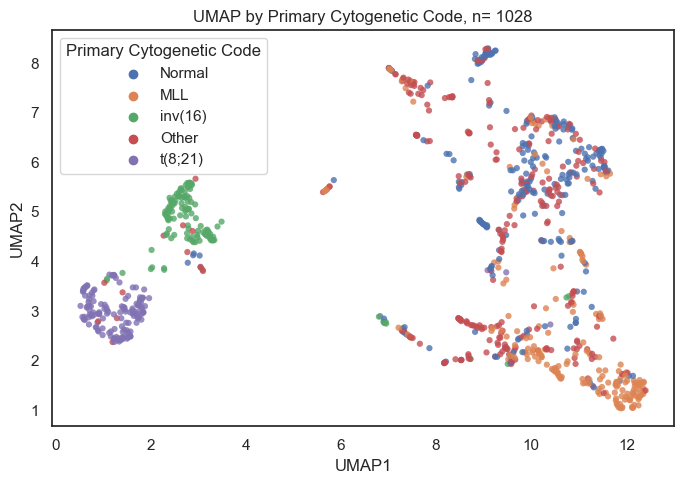

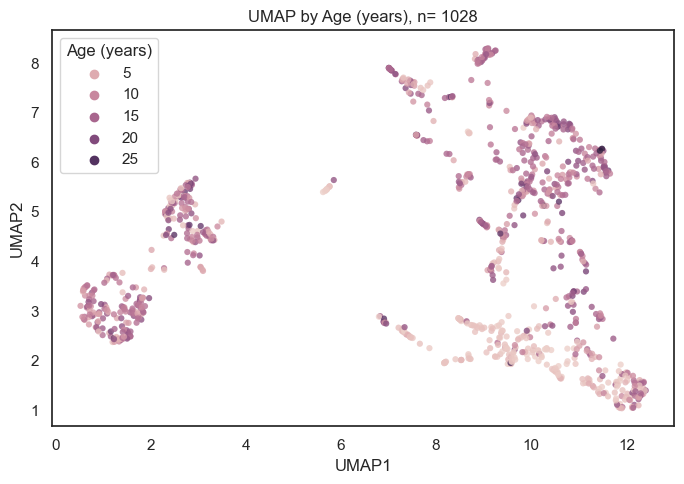

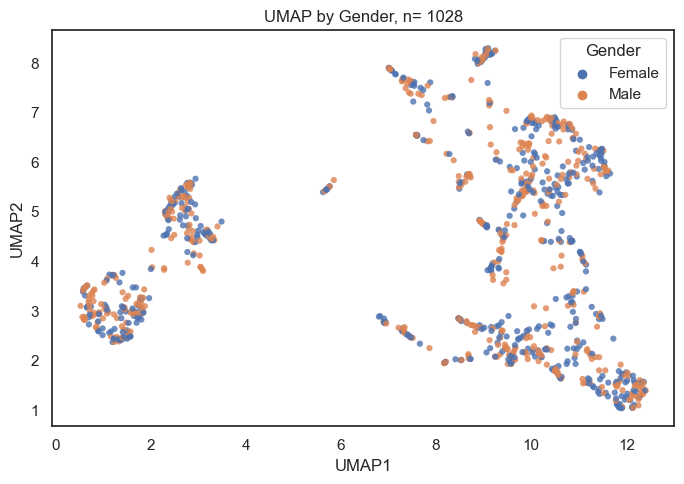

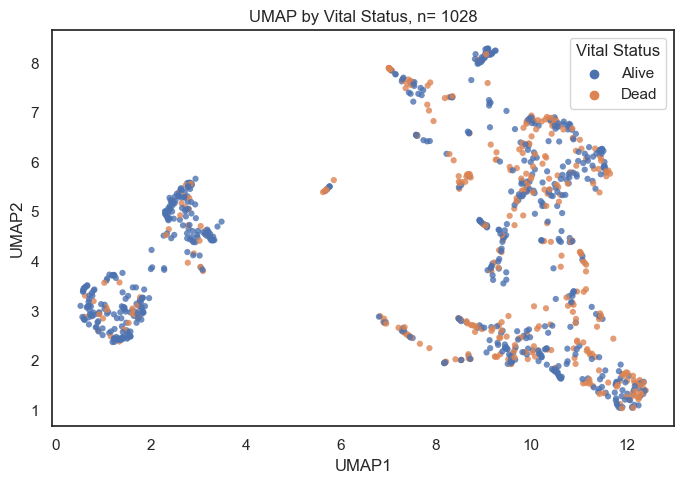

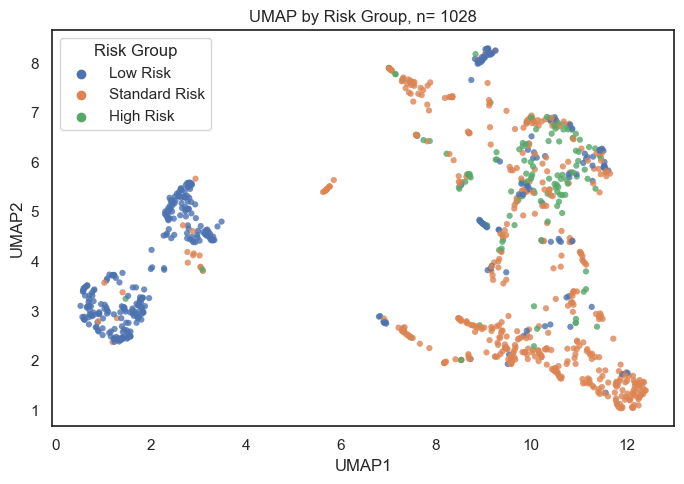

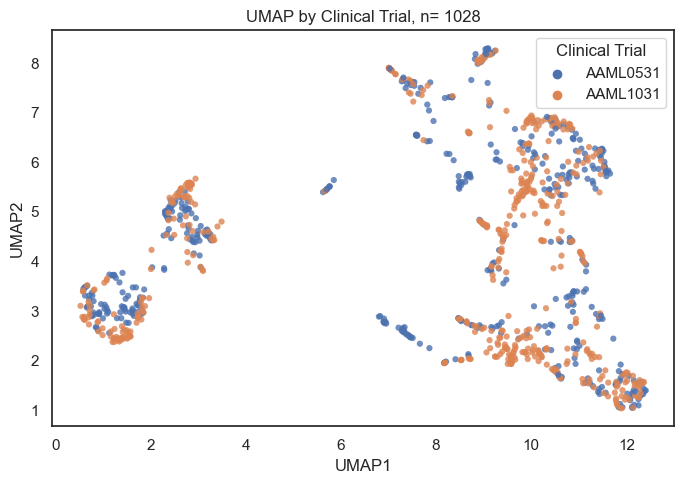

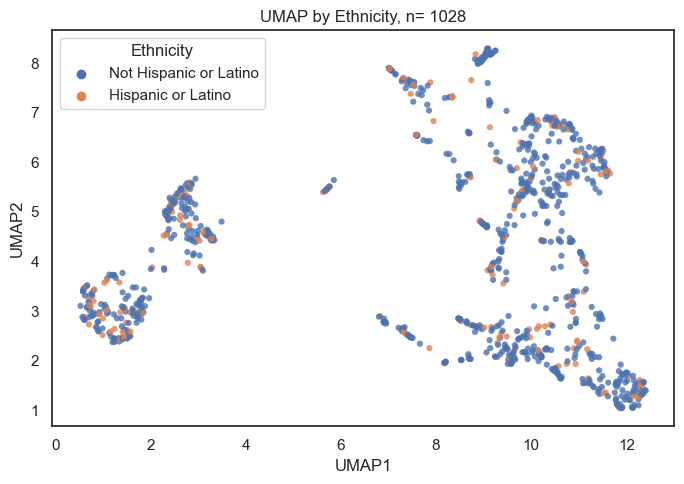

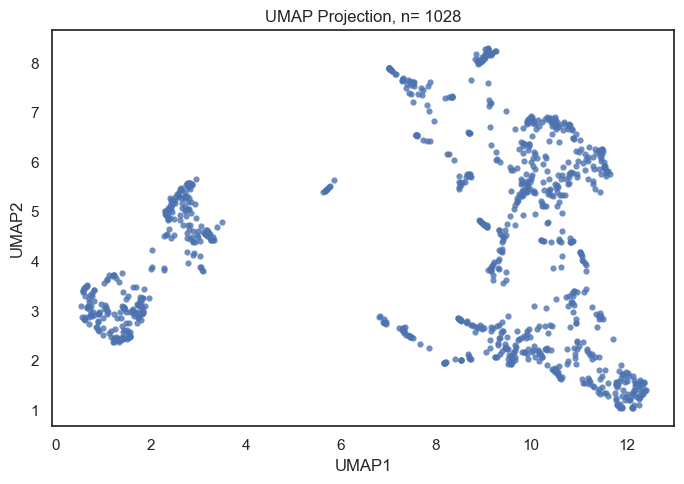

In [18]:
# Call the UMAP function.
draw_UMAP(x_umap, hue= 'Primary Cytogenetic Code')
draw_UMAP(x_umap, hue= 'Age (years)')
draw_UMAP(x_umap, hue= 'Gender')
draw_UMAP(x_umap, hue= 'Vital Status')
draw_UMAP(x_umap, hue= 'Risk Group')
draw_UMAP(x_umap, hue= 'Clinical Trial')
draw_UMAP(x_umap, hue= 'Ethnicity')
draw_UMAP(x_umap)

In [19]:
from bokeh.plotting import  output_notebook

def run_UMAP(df):
    mapper = umap.UMAP(random_state=42,n_neighbors=5, min_dist=0.001, n_jobs=-1, n_epochs=1000).fit(df)
    return(mapper)

def draw_bokeh_plot(data, labels, color):
    import umap.plot
    from bokeh.plotting import  show
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    labels2 = labels.reset_index().astype(str)
    p = umap.plot.interactive(data, point_size=4, labels=labels2[color],
    hover_data=labels2[['WHO Classification']],
    alpha=.8, theme='inferno', height=600, width=600)

    return(show(p))

In [20]:
output_notebook()

Loading BokehJS ...

In [21]:
amlCOG = run_UMAP(x_train_m)

In [22]:
color = 'WHO Classification'
draw_bokeh_plot(amlCOG, labels2, color)

## Run EWAS

### Pre-Processing

Steps:

1. Make dataframe out of UMAP results
2. Merge umap df with covariates, phenotype, and trial info
3. Split df by trial
4. Join outcome and verify binary ratio
5. Run adjusted EWAS

In [23]:
import methylize
from statsmodels.stats.multitest import multipletests

c:\ProgramData\mambaforge\lib\site-packages\bs4\element.py:15: UserWarning: The soupsieve package is not installed. CSS selectors cannot be used.
  warnings.warn(


In [24]:
# Normalize values such that they lie between 0 and 1
# then log2 transform (to align with CpG m value distribution)

def zScore (df):
    '''Standardize (z-scoring) such that mean=0 and std=3
        Note that std=3. This is an intentional deviation
        to align the distribution range to that of m-values
        of our features'''
    return ((df - df.mean())/(df.std()))

def Normalize (df):
    '''Normalize values such that they lie between 0 and 1'''
    return ((df - df.min())/(df.max()-df.min()))

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

def impute_by_mean(df):
    '''Impute missing values by computing feature average'''
    return df.fillna(df.mean())

In [25]:
# Make dataframe out of umap results
# umap_df = pd.DataFrame(x_umap, columns=['UMAP 1','UMAP 2'], index=df.index)
df['Risk Group Bin'] = df['Risk Group'].map({'Low Risk':-1, 'Standard Risk':0,'High Risk':1})
covar_os = round(impute_by_mean(df[['os.evnt','Risk Group Bin']]),3)
covar_efs = round(impute_by_mean(df[['efs.evnt','Risk Group Bin']]),3)

# Of course the imputed mean will be zero because the df is z-scored, 
# but leaving it as such in case we decide to use different scaling method.

### Run EWAS

In [26]:
# ewasOS = methylize.diff_meth_pos(meth_data=x_train_m,
#                                     pheno_data=covar_os,
#                                     column='os.evnt',
#                                     covariates=True,
#                                     regression_method="logistic",
#                                     export='pkl',
#                                     filename='../Data/EWAS_Results/ewas_cog_os')

ewasOS = pd.read_pickle('../Data/EWAS_Results/ewas_cog_os.pkl')

In [27]:
# ewasEFS = methylize.diff_meth_pos(meth_data=x_train_m,
#                                     pheno_data=covar_efs,
#                                     column='efs.evnt',
#                                     covariates=True,
#                                     regression_method="logistic",
#                                     export='pkl',
#                                     filename='../Data/EWAS_Results/ewas_cog_efs')

ewasEFS = pd.read_pickle('../Data/EWAS_Results/ewas_cog_efs.pkl')

In [28]:
# ewasEFS_un = methylize.diff_meth_pos(meth_data=x_train_m,
#                                     pheno_data=covar_efs['efs.evnt'],
#                                     covariates=False,
#                                     regression_method="logistic",
#                                     export='pkl',
#                                     filename='../Data/EWAS_Results/ewas_cog_efs_unadjusted')

ewasEFS_un = pd.read_pickle('../Data/EWAS_Results/ewas_cog_efs_unadjusted.pkl')

In [29]:
# ewasOS_un = methylize.diff_meth_pos(meth_data=x_train_m,
#                                     pheno_data=covar_os['os.evnt'],
#                                     covariates=False,
#                                     regression_method="logistic",
#                                     export='pkl',
#                                     filename='../Data/EWAS_Results/ewas_cog_os_unadjusted')

ewasOS_un = pd.read_pickle('../Data/EWAS_Results/ewas_cog_os_unadjusted.pkl')

### Manhattan Plots

saved ../Figures/Manhattan_Plots/ewas_os_risk_adjusted


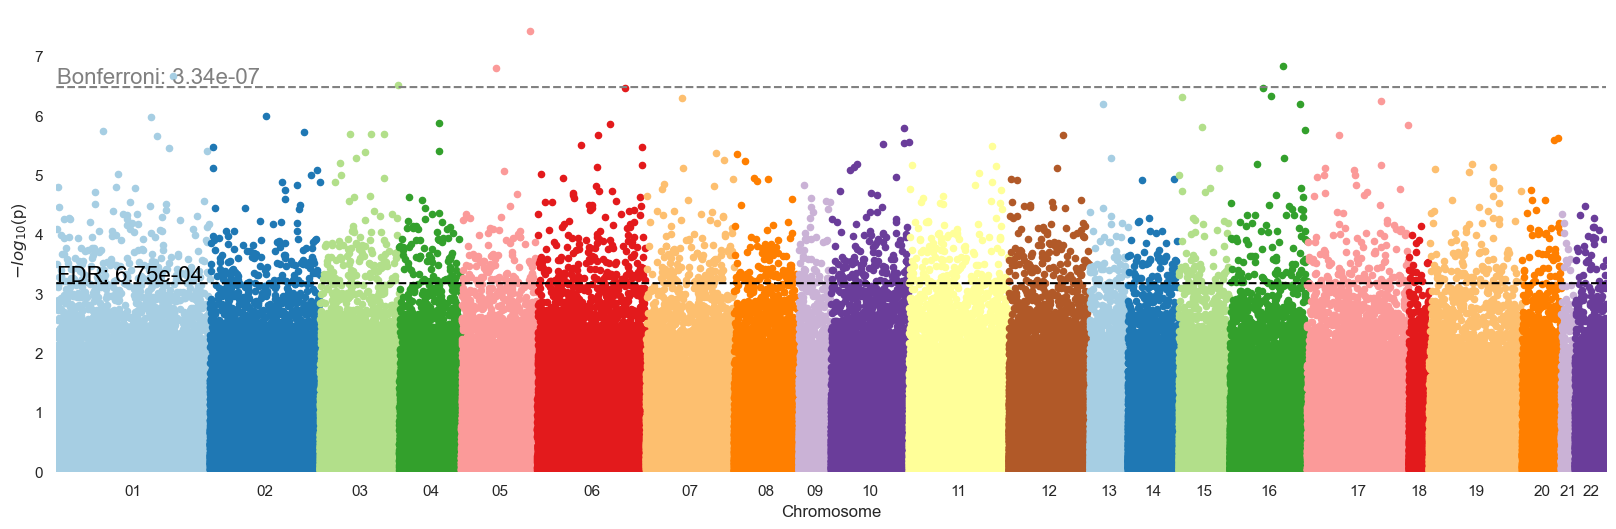

In [423]:
methylize.manhattan_plot(stats_results=ewasOS,
                        palette='Paired',
                        save=True,
                        suggestive=False,
                        significant= False,
                        width=20,
                        height=6,
                        statsmode=True,
                        fontsize=16,
                        array_type='450k',
                        explore=False,
                        label_sig_probes=False,
                        filename='../Figures/Manhattan_Plots/ewas_os_risk_adjusted')

saved ../Figures/Manhattan_Plots/ewas_os_unadjusted


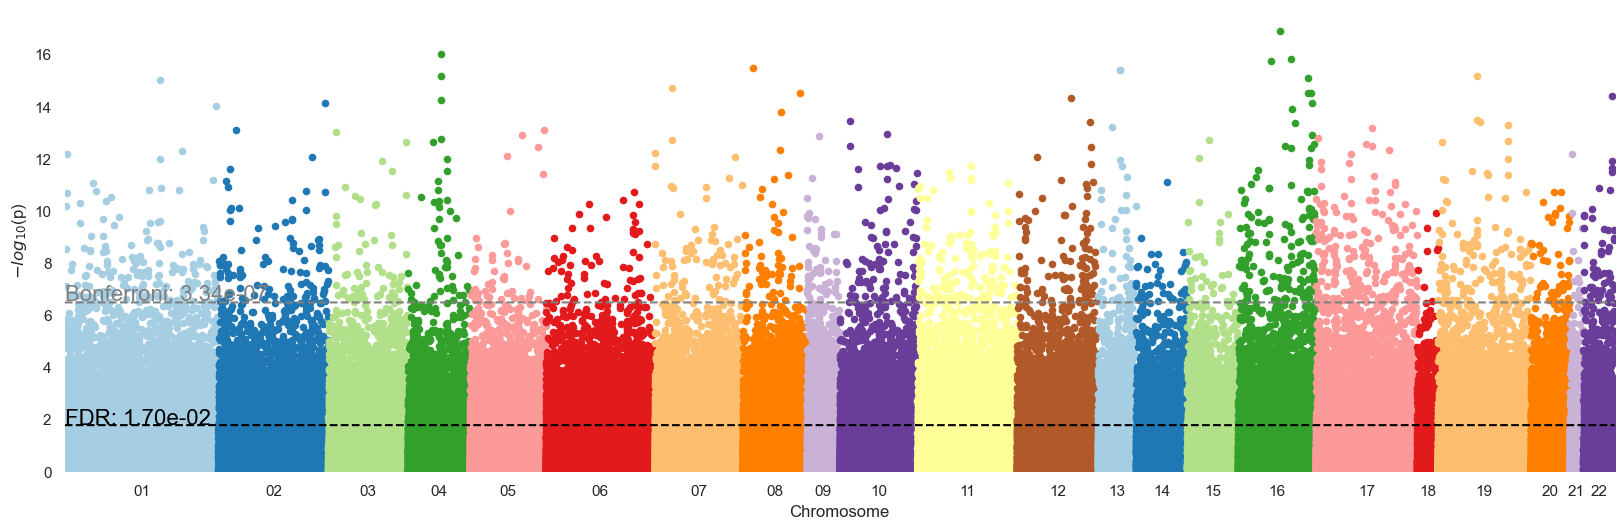

In [424]:
methylize.manhattan_plot(stats_results=ewasOS_un,
                        palette='Paired',
                        save=True,
                        suggestive=False,
                        significant= False,
                        width=20,
                        height=6,
                        statsmode=True,
                        fontsize=16,
                        array_type='450k',
                        explore=False,
                        label_sig_probes=False,
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')

saved ../Figures/Manhattan_Plots/ewas_efs_risk_adjusted


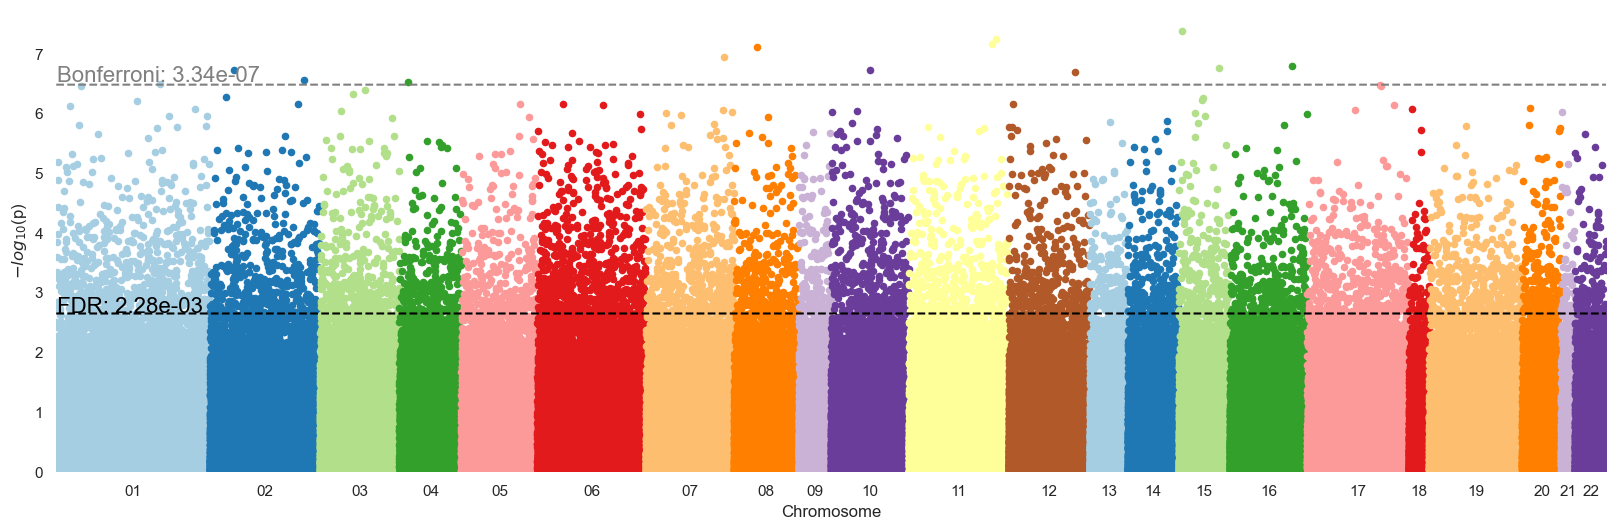

In [425]:
methylize.manhattan_plot(stats_results=ewasEFS,
                        palette='Paired',
                        save=True,
                        suggestive=False,
                        significant= False,
                        width=20,
                        height=6,
                        statsmode=True,
                        fontsize=16,
                        array_type='450k',
                        explore=False,
                        label_sig_probes=False,
                        filename='../Figures/Manhattan_Plots/ewas_efs_risk_adjusted')

saved ../Figures/Manhattan_Plots/ewas_efs_unadjusted


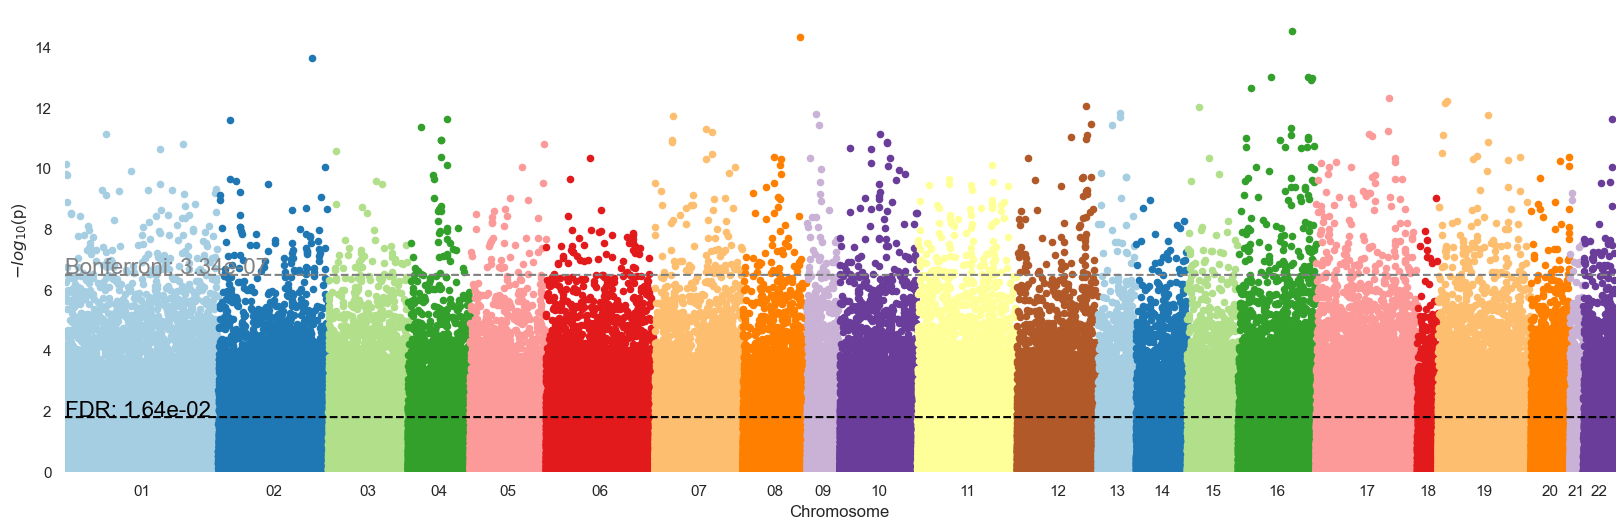

In [426]:
methylize.manhattan_plot(stats_results=ewasEFS_un,
                        palette='Paired',
                        save=True,
                        suggestive=False,
                        significant= False,
                        width=20,
                        height=6,
                        statsmode=True,
                        fontsize=16,
                        array_type='450k',
                        explore=False,
                        label_sig_probes=False,
                        filename='../Figures/Manhattan_Plots/ewas_efs_unadjusted')

## Perform Lasso

### Define Cox-Lasso Functions

In [34]:
def get_top_ewas_features(ewasOS,ewasEFS, n_features=1000):

    """Feature extraction based on EWAS bonferroni and FDR corrections
    
    Given resulting dfs from 'methylize.manhattan_plot',
    this function selects overlaping significant features given
    FDR and bonferroni corrections. 

    Args:
        ewasOS: df from methylize package contaning results from ewas with overall survival as outcome
        ewasEFS: df from methylize package contaning results from ewas with event-free-survival as outcome
        n_features: top features to select. Default=100
        
    Returns: fdr_top, bonferroni_top"""

    import warnings
    warnings.filterwarnings("ignore")

    # Define Bonferroni Cutoff
    bonferroniOS = ewasOS[ewasOS['PValue'] <= (0.05/ewasOS.shape[0])]
    bonferroniEFS = ewasEFS[ewasEFS['PValue'] <= (0.05/ewasEFS.shape[0])]

    # Define FDR_QValue Cutoff
    fdr_os = ewasOS[ewasOS['FDR_QValue'] <= 0.05]
    fdr_efs = ewasEFS[ewasEFS['FDR_QValue'] <= 0.05]

    # Use significant CpGs in the intersection of (overlaping in) both OS and EFS
    bonferroni = bonferroniOS[bonferroniOS.index.isin(list(bonferroniEFS.index))]
    fdr = fdr_os[fdr_os.index.isin(list(fdr_efs.index))]

    # Take the absolute value of coefficients
    fdr['AbsCoeff'] = abs(fdr['Coefficient'])
    bonferroni['AbsCoeff'] = abs(bonferroni['Coefficient'])

    # Take top x (n_features) CpGs based on absolute value of coefficients
    fdr_top = fdr.sort_values(by='AbsCoeff', ascending=False).iloc[:n_features,:]
    bonferroni_top = bonferroni.sort_values(by='AbsCoeff', ascending=False).iloc[:n_features,:]
    
    return(fdr_top,bonferroni_top)

In [129]:
def train_coxph_lasso(df = df, train_x= None, alpha_ratio= 0.25, loops=10):
    """Fits and tests a Cox PH regression model.

    Args:
        df: dataframe from training (discovery) dataset containg outcome labels
            Note: labels need to be: os.evnt, os.time, efs.evnt, efs.time
        train_x: features from training df
        alpha_ratio: Determines minimum alpha of the regularization path
        loops: int, default=10
        
    Returns: A df containing the calculated coefficients"""

    # Import libraries for Cox-Lasso regression
    from sksurv.util import Surv
    from sksurv.linear_model import CoxnetSurvivalAnalysis
    from sklearn.model_selection import GridSearchCV, KFold
    from sklearn.pipeline import make_pipeline
    from tqdm import tqdm

    print(f'Running Cox-Lasso through {loops} loops:')
    
    # Define x and y
    Y = Surv.from_dataframe("efs.evnt", "efs.time", df)
    X = train_x
    
    # Define range of alpha penalties to deploy
    # Note: alpha here means the constant that scales the lasso (L1) penalty in the cost function of the algorithm
    estimated_alphas = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio= alpha_ratio, n_alphas=15).fit(X,Y).alphas_

    # Fit Cox-Lasso by calculating the ideal alpha and feature coefficients through 10-fold
    # cross-validation and random seed set to z number of loops (according to "loops")
    coefs = pd.DataFrame(index=X.columns)
    b = np.arange(loops)
    
    for i in tqdm(b):
        cv = KFold(n_splits=10, shuffle=True, random_state=i)
        gcv = GridSearchCV(make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0)),
            param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
            cv=cv, error_score=0.5,n_jobs=-1).fit(X,Y)
        coefs = coefs.join(pd.DataFrame(gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"].coef_,
                            index=X.columns,columns=['coef_' + str(i)]))
    print('Cox-Lasso Trained Successfuly!')

    # Select non-zero features (those not brought to 0 by the L1 (lasso) penalty)
    coefs['nonzero_count'] = coefs.astype(bool).sum(axis=1)
    coefs['nonzero_freq'] = coefs['nonzero_count']/b[-1]
    coefs.sort_values(by=['nonzero_freq'], ascending = False, inplace=True)
    coefs2 = coefs[coefs['nonzero_freq'] != 0]

    # Set feature inclusion threshold (only features present in 80% of loops will be taken)
    coefs2 = coefs[coefs['nonzero_freq'] > 0.8].replace(0, np.NaN).drop(columns=['nonzero_count','nonzero_freq'])

    # Get the mean values of selected coefficients, ignoring 0s
    coef_mean = coefs2.mean(axis=1,skipna=True).sort_values(ascending=False)
    return(coef_mean)

In [44]:
def generate_coxph_score(coef_mean, x, df, score_name, train_test='train',
                         cutoff_train=0.5):
    """Generates score/Cox PH predictions
    
    Args:
        coef_mean: list of mean coeficients from CoxPH fit
        df: dataframe to add your results to
        x: m-values or features that will be used to calculate the score
        score_name: name of your score/prediction column
        train_test: use 'train' or float between 0,1 for cutoff percentile.
                    If test, use number for binary threshold/cutoff.
        cutoff: only matters if 'train' is selected in 'train_test' arg. 
                cutoff is within (0,1) and defines cutoff percentile for
                categorical score. 
    Returns:
        Dataframe with calculated quantitative and categorical score/model
        predictions.
    """

    # Calculate score in test(validation) data
    b = np.arange(len(coef_mean))
    df2 = pd.DataFrame()

    for i in b:
        df2['coef_' + str(i)] = x[coef_mean.index[i]].apply(lambda x: x * coef_mean[i])

    df3 = df2.iloc[:,(df2.shape[1] - coef_mean.shape[0]):df2.shape[1]]

    # Save calculated score as a separate column of the original dataframe
    df[score_name] = df3.sum(axis=1)

    # Determine train
    if train_test == 'train':
        i = np.quantile(df[score_name],cutoff_train)
    else:
        i = train_test

    # Binarize score
    df[score_name +' Categorical'] = pd.cut(df[score_name],
                                            bins=[-np.inf,i,np.inf],
                                            labels = ['Low','High'])

    df[score_name + '_cat_bin'] = pd.cut(df[score_name],
                                         bins=[-np.inf,i,np.inf],
                                         labels = [0,1])
    
    return(df)

In [42]:
def get_coxph_results(model_predictions=None, df_labels=None):

    from lifelines import CoxPHFitter

    # Create df that contains features and labels/outcome
    cph_os = model_predictions.to_frame().join(df_labels[['os.evnt','os.time']])
    cph_efs = model_predictions.to_frame().join(df_labels[['efs.evnt','efs.time']])

    # Fit Cox PH regression
    cph1 = CoxPHFitter()
    cph2 = CoxPHFitter()
    hz_efs = cph1.fit(cph_efs, 'efs.time', event_col='efs.evnt')
    hz_os = cph2.fit(cph_os, 'os.time', event_col='os.evnt')

    # Create df of results
    d = {'Overall Survival': [hz_os.hazard_ratios_[0], hz_os.summary['p'][0]],
         'Event-free Survival': [hz_efs.hazard_ratios_[0], hz_efs.summary['p'][0]]}

    cox_results = pd.DataFrame(data=d,index=['Hazard Ratio','P-Value'])
    return(cox_results)

### Execute Functions

In [343]:
fdr, bonferroni = get_top_ewas_features(ewasOS_un,ewasEFS_un, n_features=5000)

x_ewas = x_train_m[list(fdr.index)]

coef_mean = train_coxph_lasso(df = df,train_x = x_ewas,
                              alpha_ratio= 0.25, loops=1000)

Running Cox-Lasso through 1000 loops:


100%|██████████| 1000/1000 [1:56:34<00:00,  6.99s/it]

Cox-Lasso Trained Successfuly!


In [344]:
score_train = generate_coxph_score(coef_mean=coef_mean, df=df, x=x_train_m,
                                   score_name='MethylScore',train_test='train',
                                   cutoff_train=0.6)


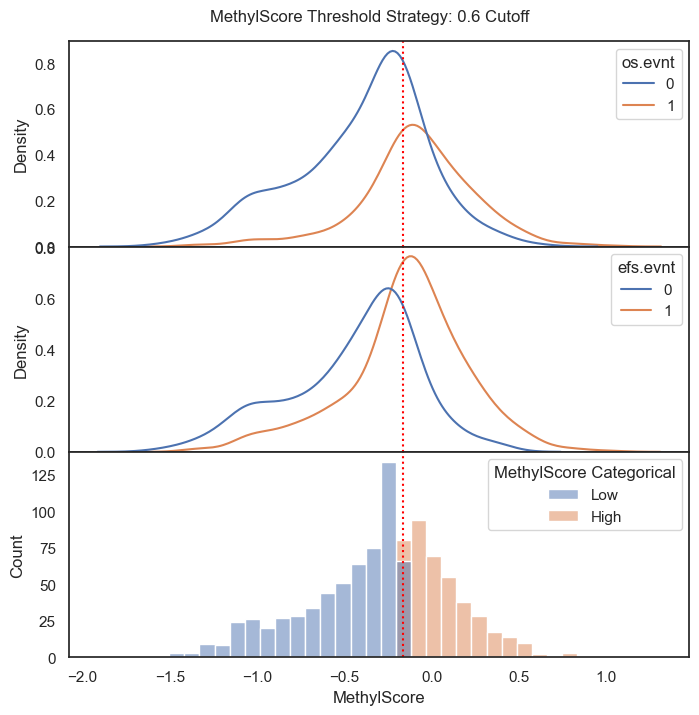

In [370]:
# Set up the matplotlib figure
sns.set_theme(style='white', context='notebook')
f, axs = plt.subplots(3, 1, sharex=True, figsize=(8,8))

# Define plots
sns.kdeplot(data=score_train,x='MethylScore', hue='os.evnt', ax=axs[0]) 
sns.kdeplot(data=score_train,x='MethylScore', hue='efs.evnt', ax=axs[1])
sns.histplot(data=score_train,x='MethylScore', hue='MethylScore Categorical', ax=axs[2])

# Set specs
for i in range(3):
    axs[i].axvline(np.quantile(score_train['MethylScore'],0.6), linestyle="dotted",color='red')


plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("MethylScore Threshold Strategy: 0.6 Cutoff",y=0.92,fontsize='medium')
plt.show()

In [346]:
cutoff = np.quantile(score_train['MethylScore'],0.6)

In [347]:
score_test1 = generate_coxph_score(coef_mean=coef_mean, df=df_aml02, x=x_test1_m,
                                   score_name='MethylScore',train_test=cutoff)

score_test2 = generate_coxph_score(coef_mean=coef_mean, df=df_aml08, x=x_test2_m,
                                   score_name='MethylScore',train_test=cutoff)

score_test3 = generate_coxph_score(coef_mean=coef_mean, df=df03p1, x=x_test3_m,
                                   score_name='MethylScore',train_test=cutoff)

In [373]:

results = get_coxph_results(model_predictions = score_train['MethylScore'], 
                            df_labels = df)
results1 = get_coxph_results(model_predictions = score_test1['MethylScore'], 
                            df_labels = df_aml02)
results2 = get_coxph_results(model_predictions = score_test2['MethylScore'],
                            df_labels = df_aml08)
results3 = get_coxph_results(model_predictions = score_test3['MethylScore'],
                            df_labels = df03p1)

test = round(pd.concat([results,results1,results2,results3],
                 keys=['AAML0531/1031','AML02','AML08','AAML03P1']),4)
test

Overall Survival  Event-free Survival
AAML0531/1031 Hazard Ratio            6.6975               5.7392
              P-Value                 0.0000               0.0000
AML02         Hazard Ratio            2.0178               2.9067
              P-Value                 0.1227               0.0074
AML08         Hazard Ratio            3.1512               2.7628
              P-Value                 0.1672               0.1354
AAML03P1      Hazard Ratio            4.2332               5.8588
              P-Value                 0.0774               0.0118

In [350]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_score=score_test1['MethylScore_cat_bin'], y_true=df_aml02['os.evnt'])

0.5751658069270449

In [351]:
roc_auc_score(y_score=score_train['MethylScore_cat_bin'], y_true=df['os.evnt'])

0.6966519925857274

## Plot Kaplan-Meiers

In [374]:
def KM_plot(scorename, scorename_cat, df, save_plot=False,
            add_risk_counts=False, save_survival_table=False,
            trialname=None, show_ci=False):

    """Returns a Kaplan-Meier plot with:

        1. Hazard Ratio
        2. P-value
        3. Risk counts
        4. Survival table

    """
    # Import libraries for Kaplan Meier
    from lifelines.plotting import add_at_risk_counts
    from lifelines import KaplanMeierFitter
    from lifelines import CoxPHFitter

    # Set up the matplotlib figure
    sns.set_theme(style='white', context='notebook')
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8,8))
    
    # Define survival curve categories
    groups = df[scorename_cat]
    ix = (groups == 'High')

    # Fit the Kaplan Meier to each category of groups (kmf1 and kmf2)
    def surv_curves(i,t,e):

        T = df[t]
        E = df[e]
        kmf1 = KaplanMeierFitter()
        kmf1.fit(T[~ix], E[~ix], label='Low-' + scorename + ', n=' + str(len(df[df[scorename_cat].isin(['Low'])])))
        ax = kmf1.plot_survival_function(ax=i,show_censors=True,ci_show=show_ci)

        kmf2 = KaplanMeierFitter()
        kmf2.fit(T[ix], E[ix], label='High-' + scorename + ', n=' + str(len(df[df[scorename_cat].isin(['High'])])))
        ax = kmf2.plot_survival_function(ax=i,show_censors=True,ci_show=show_ci)
        
        # Calculate Hazard Ratio (HZ) and p-value (p)
        X_CPH = df[[scorename+'_cat_bin',t,e]]
        cph = CoxPHFitter()
        HZ = cph.fit(X_CPH, t, event_col=e)
        hz = HZ.hazard_ratios_[0]
        p = HZ.summary['p'][0]
        
        # Annotate HZ and p
        i.annotate(f'Hazard Ratio: {hz:.4f}\np-value: {p:.4f}',
                    xy=(9.75, 0.085), xycoords='data',
                    ha='right', va='center', fontsize=11,
                    bbox={'boxstyle': 'round', 'facecolor': 'none',
                    'edgecolor': 'lightgray'})

        # Add risk counts below the graph
        if add_risk_counts == True:
            add_at_risk_counts(kmf1, kmf2, ax=i)

        # Save Survival Function Table
        if save_survival_table == True:
            surv1 = kmf1.survival_function_.join(kmf1.confidence_interval_)
            surv2 = kmf2.survival_function_.join(kmf2.confidence_interval_)
            surv3 = surv1.join(surv2, how='outer')
            surv3.to_csv('../Figures/Kaplan_Meiers/KM_OS_SurvivalTable_' + scorename +'_'+ trialname + '_' + str(len(df)) + '.csv')

        i.set_ylim(0, 1)
        i.set_ylabel("est. probability of survival $\hat{S}(t)$")
        return(ax)

    ax1 = surv_curves(i=ax[0],t='efs.time',e='efs.evnt')
    ax2 = surv_curves(i=ax[1],t='os.time',e='os.evnt')

    ax[0].set_title('A) Event-Free Survival', loc='left', pad=10, fontweight='bold')
    ax[1].set_title('B) Overall Survival',loc='left', pad=10, fontweight='bold')
    # Define Plot Specs
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.suptitle("Kaplan-Meier Analysis of " + scorename + " in " + trialname + ", n=" + str(len(df)),
                 fontsize = 'medium', y=0.94,
    fontweight='bold') 
    plt.xlim(0, 10)
    plt.xlabel("time $t$ (years)")
    
    # Save plot figure
    if save_plot == True:
        plt.savefig('../Figures/Kaplan_Meiers/' + scorename +'_'+ trialname + '_' + str(len(df)) + '.png',
                    bbox_inches='tight', dpi=300)

    return(plt.show())

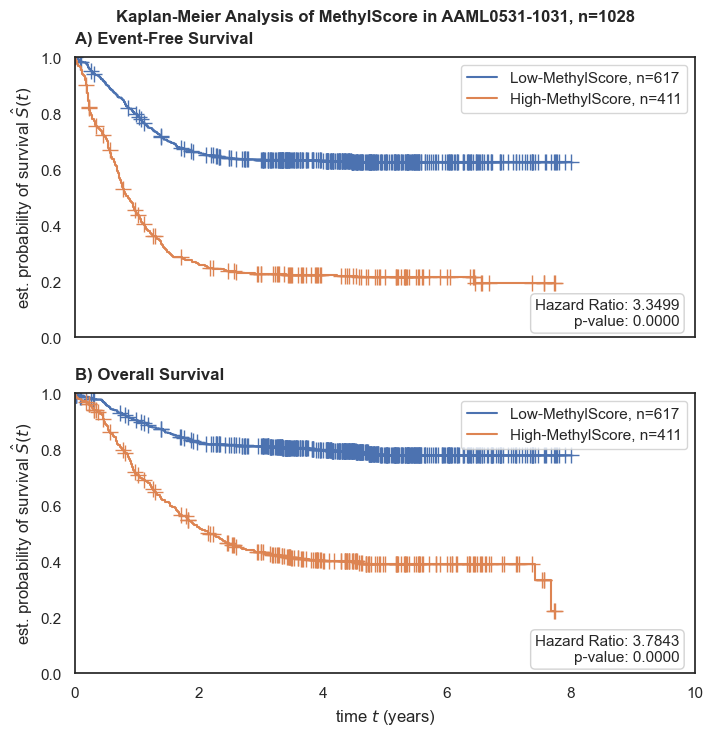

In [375]:
KM_plot(scorename='MethylScore', scorename_cat='MethylScore Categorical',
        df=score_train, save_plot=True, add_risk_counts=False,
        trialname='AAML0531-1031')

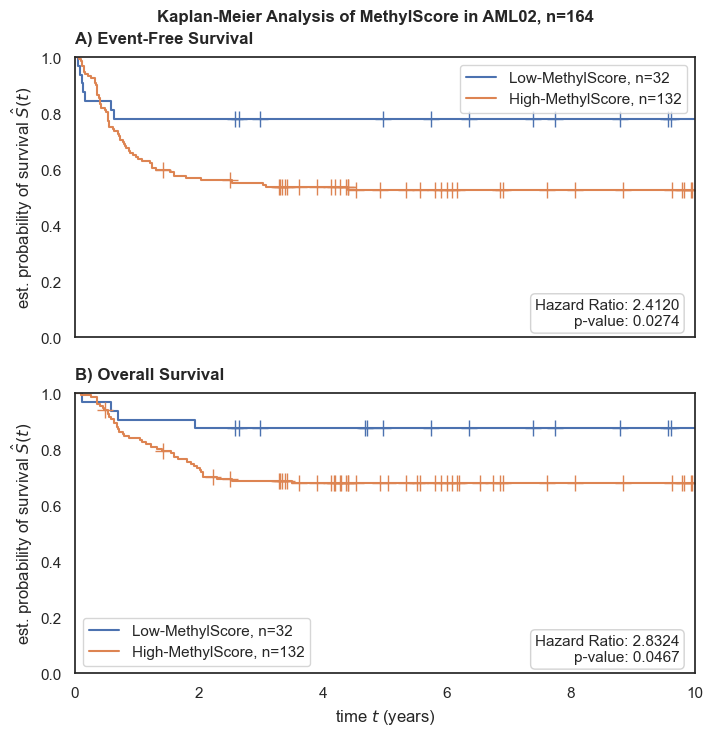

In [376]:
KM_plot(scorename='MethylScore', scorename_cat='MethylScore Categorical',
        df=score_test1, save_plot=True, add_risk_counts=False,
        trialname='AML02')

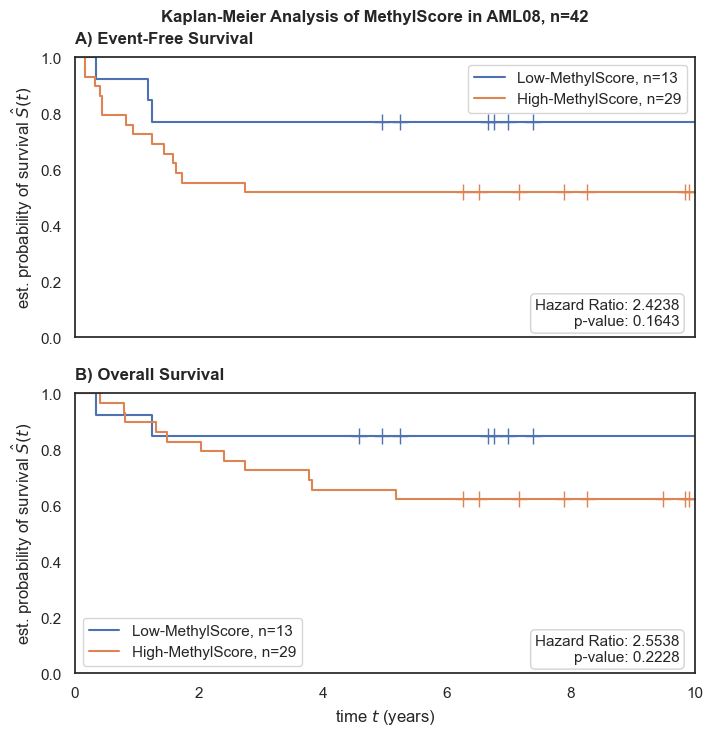

In [377]:
KM_plot(scorename='MethylScore', scorename_cat='MethylScore Categorical',
        df=score_test2, save_plot=True, add_risk_counts=False,
        trialname='AML08')

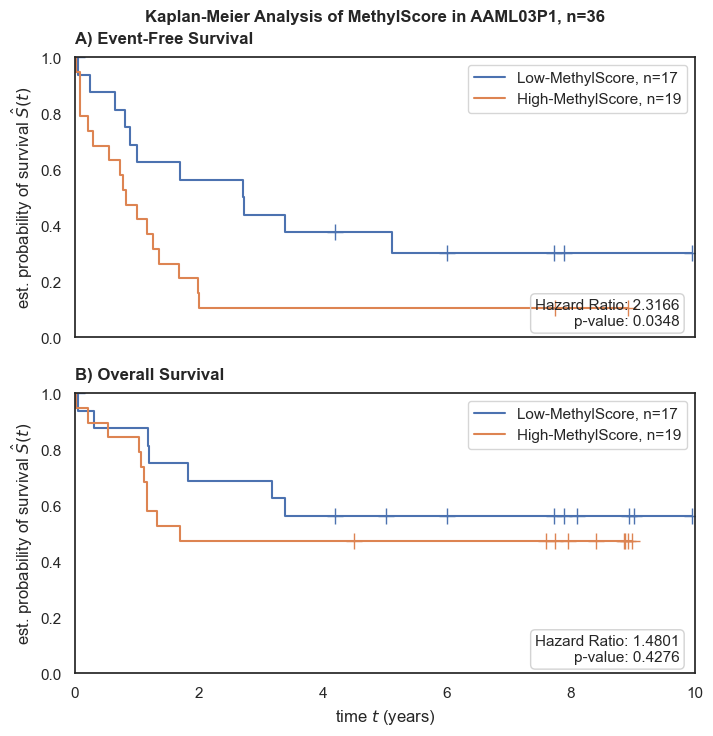

In [378]:
KM_plot(scorename='MethylScore', scorename_cat='MethylScore Categorical',
        df=score_test3, save_plot=True, add_risk_counts=False,
        trialname='AAML03P1')

## Probe Mapping

In [383]:
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv', sep='\t',index_col=0)
probe_map = coef_mean.to_frame('MethylScore Coefficients').join(zhou2016_probes, how='inner')

In [385]:
probe_map.to_csv('../Figures/Tables/methylscore_cpgs.csv')

In [445]:
probe_map[['MethylScore Coefficients','GeneNames','GeneClasses']].head()

,MethylScore Coefficients,GeneNames,GeneClasses
cg02678414,0.080760,TRAF7;TRAF7;TRAF7;TRAF7;TRAF7,protein_coding;protein_coding;protein_coding;p...
cg21925414,0.044445,.,.
cg00192882,0.034873,MFAP4;MFAP4;MFAP4;MFAP4,protein_coding;protein_coding;protein_coding;p...
cg23930083,0.024441,NAT16;NAT16;NAT16,protein_coding;protein_coding;protein_coding
cg03241244,0.023714,KDM2B;KDM2B;KDM2B;KDM2B;KDM2B;KDM2B;KDM2B;KDM2...,protein_coding;protein_coding;protein_coding;p...
cg16314254,0.023293,GALNT2;GALNT2,protein_coding;protein_coding
cg24397815,0.017710,.,.
cg14037250,0.016590,BRD3;BRD3;BRD3;BRD3;RP11-374P20.4,protein_coding;protein_coding;protein_coding;p...
cg08107308,0.016449,HDAC4;HDAC4;HDAC4;HDAC4,protein_coding;protein_coding;protein_coding;p...
cg12731773,0.014243,TSPAN4;TSPAN4;TSPAN4;TSPAN4;TSPAN4;TSPAN4;TSPA...,protein_coding;protein_coding;protein_coding;p...
